# CG(TVなし)

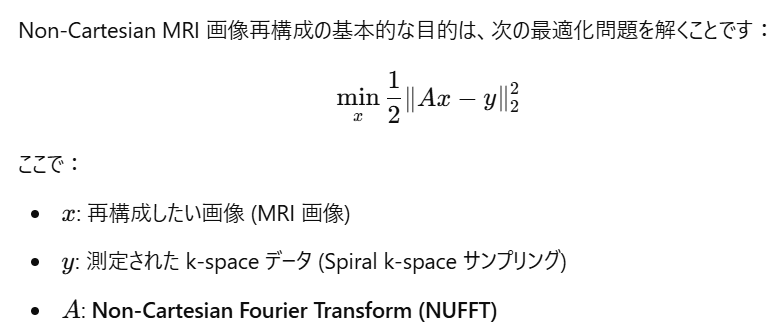

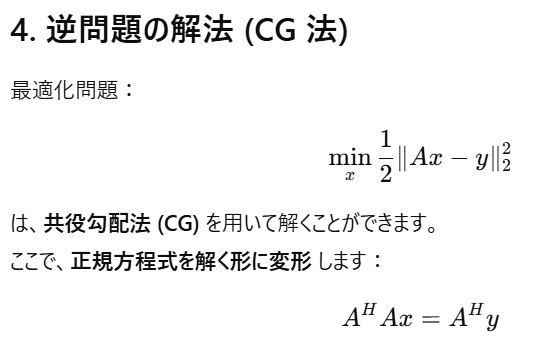

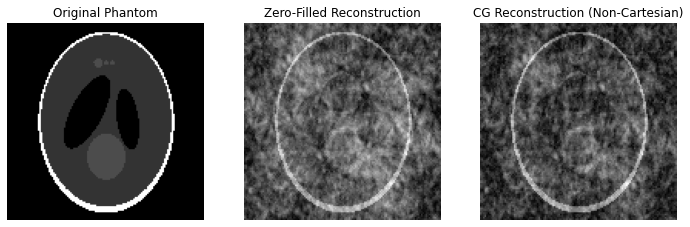

In [1]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# **1. Shepp-Logan Phantom の作成**
N = 128  # 画像サイズ
phantom = sp.shepp_logan((N, N))

# **2. Spiral k-space (Non-Cartesian サンプリング) の作成**
coords = mri.spiral(
    fov=0.3,         # 視野 (FOV) 30cm
    N=N,             # 画像サイズ
    f_sampling=1.0,  # サンプリングファクター
    R=3,             # Undersampling rate
    ninterleaves=1,  # Interleaves の数
    alpha=1.0,       # 可変密度 Spiral の設定
    gm=0.04,         # 最大勾配強度
    sm=150,          # 最大スルーレート
)

# **3. Non-Cartesian Fourier Transform の設定**
nufft_op = sp.linop.NUFFT(phantom.shape, coord=coords)  # NUFFT オペレータ
nufft_adj = nufft_op.H  # Adjoint Operator

# **4. Spiral サンプリング適用 (Non-Cartesian k-space)**
kspace_sampled = nufft_op(phantom)  # NUFFT による Spiral サンプリング

# **5. Zero-Filled Reconstruction**
img_zero_filled = nufft_adj(kspace_sampled).astype(np.complex128)

# **6. CG 法を用いた Non-Cartesian MRI 再構成**
AHA = nufft_adj * nufft_op  # 正規化された演算子
b = nufft_adj(kspace_sampled)  # 右辺 (A^H y)

# **7. 初期化**
x = np.zeros_like(img_zero_filled, dtype=np.complex128)  # ゼロ初期化

# **8. CG による再構成**
cg_solver = sp.alg.ConjugateGradient(AHA, b, x, max_iter=100, tol=1e-6)

while not cg_solver.done():
    cg_solver.update()

# **9. 結果を取得**
reconstructed_img = np.abs(x)  # 絶対値を取って実画像にする

# **10. 結果を可視化**
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("CG Reconstruction (Non-Cartesian)")
axs[2].axis("off")

plt.show()


# TV正則化

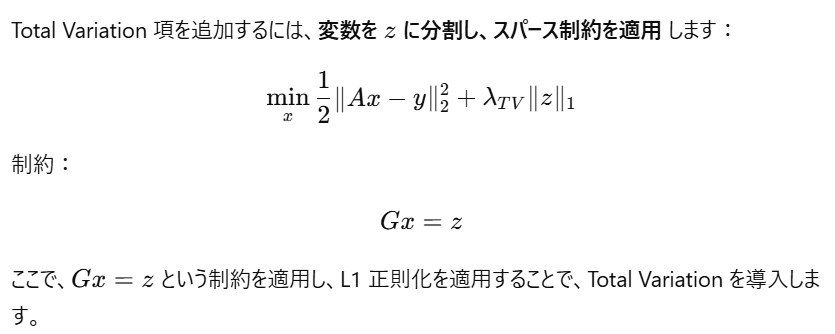

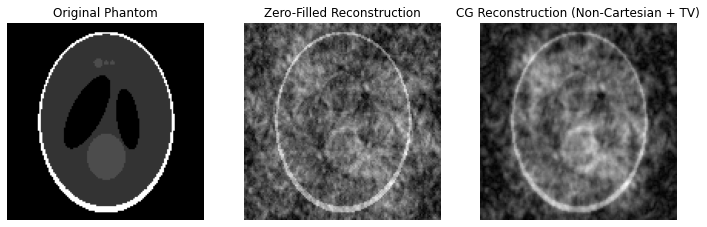

In [2]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# **1. Shepp-Logan Phantom の作成**
N = 128  # 画像サイズ
phantom = sp.shepp_logan((N, N))

# **2. Spiral k-space (Non-Cartesian サンプリング) の作成**
coords = mri.spiral(
    fov=0.3,         # 視野 (FOV) 30cm
    N=N,             # 画像サイズ
    f_sampling=1.0,  # サンプリングファクター
    R=3,             # Undersampling rate
    ninterleaves=1,  # Interleaves の数
    alpha=1.0,       # 可変密度 Spiral の設定
    gm=0.04,         # 最大勾配強度
    sm=150,          # 最大スルーレート
)

# **3. Non-Cartesian Fourier Transform の設定**
nufft_op = sp.linop.NUFFT(phantom.shape, coord=coords)  # NUFFT オペレータ
nufft_adj = nufft_op.H  # Adjoint Operator (A^H)

# **4. Spiral サンプリング適用 (Non-Cartesian k-space)**
kspace_sampled = nufft_op(phantom)  # Spiral k-space データ

# **5. Zero-Filled Reconstruction**
img_zero_filled = nufft_adj(kspace_sampled).astype(np.complex128)

# **6. TV 正則化の設定**
rho = 0.5  # TV 正則化の強さ (調整可能)

# **7. 線形オペレータ (NUFFT + TV)**
A = nufft_op  # Spiral のサンプリング行列
G = sp.linop.FiniteDifference(phantom.shape, axes=[0, 1])  # TV 正則化の微分演算子

# **8. CG 法を用いた Non-Cartesian MRI + TV 正則化**
AHA = A.H * A + rho * G.H * G  # 正規化された演算子
b = A.H(kspace_sampled)  # 右辺 b = A^H y

# **9. 初期化**
x = np.zeros_like(img_zero_filled)  # ゼロ初期化

# **10. CG による再構成**
cg_solver = sp.alg.ConjugateGradient(AHA, b, x, max_iter=100, tol=1e-6)

while not cg_solver.done():
    cg_solver.update()

# **11. 結果を取得**
reconstructed_img = np.abs(x)  # 絶対値を取って実画像にする

# **12. 結果を可視化**
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("CG Reconstruction (Non-Cartesian + TV)")
axs[2].axis("off")

plt.show()
